In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [3]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

repsol = df[df['empresa'] == 'Repsol']

repsol.shape

(1325, 10)

In [4]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

repsol = repsol [['date','open','high','low','close','adj close']]

repsol.shape

(1325, 6)

In [5]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

repsol['date'] = pd.to_datetime(repsol['date'], format="%Y-%m-%d")

repsol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 36055 to 37379
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [6]:
# Paso 5: Ordenar el DF por fecha

repsol.sort_values(by='date',ascending= True, inplace=True)

repsol.head()

,date,open,high,low,close,adj close
37223,2019-01-02,13.980,14.310,13.785,14.235,10.366182
37224,2019-01-03,14.040,14.380,14.025,14.255,10.380747
37226,2019-01-04,14.410,14.705,14.360,14.595,10.628340
37234,2019-01-07,14.660,14.695,14.330,14.475,10.540956
37227,2019-01-08,14.445,14.790,14.440,14.490,10.551878


In [7]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

acciona = repsol[(repsol['date'] >= fecha_inicio) & (repsol['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

repsol.shape

(1325, 6)

In [8]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=repsol['date'].min(), end=repsol['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

repsol = repsol.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

repsol = repsol.rename(columns={'index': 'date'})


In [9]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

repsol.head(10)

,date,open,high,low,close,adj close
0,2019-01-02,13.980,14.310,13.785,14.235,10.366182
1,2019-01-03,14.040,14.380,14.025,14.255,10.380747
2,2019-01-04,14.410,14.705,14.360,14.595,10.628340
3,2019-01-05,NaN,NaN,NaN,NaN,NaN
4,2019-01-06,NaN,NaN,NaN,NaN,NaN
5,2019-01-07,14.660,14.695,14.330,14.475,10.540956
6,2019-01-08,14.445,14.790,14.440,14.490,10.551878
7,2019-01-09,14.600,14.745,14.455,14.695,10.701163
8,2019-01-10,14.615,14.795,14.555,14.775,10.759420
9,2019-01-11,14.785,14.900,14.600,14.750,10.741214


In [10]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

repsol = repsol.fillna(method='ffill')

In [11]:
# Paso 10: Comprobar que se han introducido los valores correctamente


repsol.head(10)

,date,open,high,low,close,adj close
0,2019-01-02,13.980,14.310,13.785,14.235,10.366182
1,2019-01-03,14.040,14.380,14.025,14.255,10.380747
2,2019-01-04,14.410,14.705,14.360,14.595,10.628340
3,2019-01-05,14.410,14.705,14.360,14.595,10.628340
4,2019-01-06,14.410,14.705,14.360,14.595,10.628340
5,2019-01-07,14.660,14.695,14.330,14.475,10.540956
6,2019-01-08,14.445,14.790,14.440,14.490,10.551878
7,2019-01-09,14.600,14.745,14.455,14.695,10.701163
8,2019-01-10,14.615,14.795,14.555,14.775,10.759420
9,2019-01-11,14.785,14.900,14.600,14.750,10.741214


In [12]:
# Paso 11: Establecer columna 'date' como índice para modelo

repsol = repsol.set_index('date')

repsol.head(10)

,open,high,low,close,adj close
date,,,,,
2019-01-02,13.980,14.310,13.785,14.235,10.366182
2019-01-03,14.040,14.380,14.025,14.255,10.380747
2019-01-04,14.410,14.705,14.360,14.595,10.628340
2019-01-05,14.410,14.705,14.360,14.595,10.628340
2019-01-06,14.410,14.705,14.360,14.595,10.628340
2019-01-07,14.660,14.695,14.330,14.475,10.540956
2019-01-08,14.445,14.790,14.440,14.490,10.551878
2019-01-09,14.600,14.745,14.455,14.695,10.701163
2019-01-10,14.615,14.795,14.555,14.775,10.759420


In [13]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

repsol.index = pd.DatetimeIndex(repsol.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

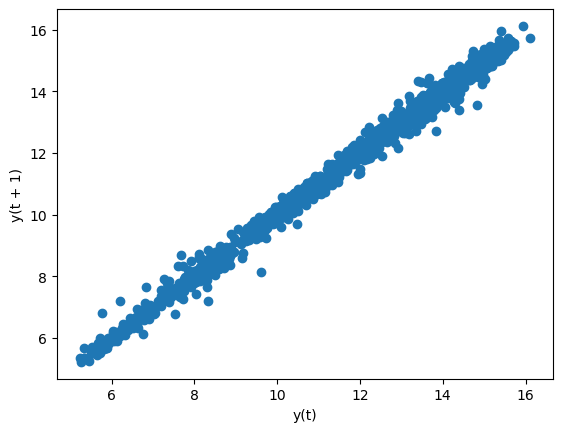

In [14]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(repsol.close)

In [15]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [16]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = repsol.close[:-10], repsol.close[-10:]

train.shape, test.shape

((1876,), (10,))

In [17]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [18]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(repsol.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    13.645277
2024-02-22    13.640567
2024-02-23    13.635870
2024-02-24    13.631186
2024-02-25    13.626515
2024-02-26    13.621857
2024-02-27    13.617212
2024-02-28    13.612579
2024-02-29    13.607959
2024-03-01    13.603352
Freq: D, dtype: float64

In [19]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    13.680
2024-02-22    14.425
2024-02-23    14.560
2024-02-24    14.560
2024-02-25    14.560
2024-02-26    14.575
2024-02-27    14.755
2024-02-28    14.610
2024-02-29    14.725
2024-03-01    14.695
Freq: D, Name: close, dtype: float64

In [20]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.8902625322544722

In [21]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,13.680,13.645277,-0.034723
2024-02-22,14.425,13.640567,-0.784433
2024-02-23,14.560,13.635870,-0.924130
2024-02-24,14.560,13.631186,-0.928814
2024-02-25,14.560,13.626515,-0.933485
2024-02-26,14.575,13.621857,-0.953143
2024-02-27,14.755,13.617212,-1.137788
2024-02-28,14.610,13.612579,-0.997421
2024-02-29,14.725,13.607959,-1.117041
2024-03-01,14.695,13.603352,-1.091648
